In [7]:
import numpy as np
from scipy.linalg import eigh, qr, null_space
import matplotlib.pyplot as plt
from scipy.sparse import kron, identity, csr_matrix, lil_matrix, dok_matrix, coo_matrix, issparse
from scipy.sparse.linalg import eigsh, eigs
from scipy.optimize import curve_fit
from qutip import Qobj, ptrace, entropy_vn, qeye, tensor
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from joblib import Parallel, delayed
#from quspin.basis import spin_basis_1d, spin_basis_general
#import tenpy as tp

In [8]:
# basis states

# spin 1/2

basis_up = np.array([1, 0])
basis_down = np.array([0, 1])

singlet = (1/np.sqrt(2)) * (np.kron(basis_up, basis_down) - np.kron(basis_down, basis_up))

In [9]:
# functions

def innermost_adjacent_indices(L, block_size):
    """
    Returns the indices of the innermost adjacent block of given size.
    For even L, the block is centered in the middle.
    """
    start = (L - block_size) // 2
    return list(range(start, start + block_size))

def all_adjacent_indices(L, block_size):
    """
    Returns a list of all possible adjacent blocks of given size.
    Each block is represented as a list of indices.
    """
    return [list(range(start, start + block_size)) for start in range(L - block_size + 1)]

def dimer(L, singlet):
    """
    Constructs the dimer state for a given even number of sites L.
    The dimer state is a superposition of two configurations.
    """
    if L % 2 != 0:
        raise ValueError("L must be an even integer.")
    
    # Create the first dimer configuration
    dimer1 = singlet
    for _ in range(1, L // 2):
        dimer1 = np.kron(dimer1, singlet)

    # Create the second dimer configuration by permuting axes
    dimer2 = dimer1.reshape([2] * L)
    dimer2 = np.transpose(dimer2, axes=list(range(1, L)) + [0])
    dimer2 = dimer2.reshape(-1)

    # Combine both configurations into a superposition
    return (1 / np.sqrt(2 + (-1 / 2) ** (L / 2 - 2))) * (dimer1 + dimer2)


def ptrace_sparse(dm_sparse, keep, dims):
    """
    Compute the partial trace over arbitrary subsystems using sparse matrix operations.

    Args:
        dm_sparse (scipy.sparse matrix): Full density matrix of shape (D, D), where D = product(dims)
        keep (list of int): Subsystems to keep (indices, 0-indexed)
        dims (list of int): List of subsystem dimensions, e.g., [2]*n for n qubits

    Returns:
        scipy.sparse.csr_matrix: Reduced density matrix over kept subsystems
    """
    if not issparse(dm_sparse):
        raise ValueError("dm_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if dm_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])
    # Prepare output
    data = []
    row_idx = []
    col_idx = []

    # Precompute bit masks
    #def idx_to_bits(idx):
    #    return np.array(list(np.binary_repr(idx, width=n))).astype(int)

    def idx_to_subsys(idx, dims):
    #Convert flat index to tuple of subsystem indices for arbitrary dims
        subsys = []
        for d in reversed(dims):
            subsys.append(idx % d)
            idx //= d
        return np.array(subsys[::-1])
    

    dm_sparse = dm_sparse.tocoo()

    ''' for i, j, val in zip(dm_sparse.row, dm_sparse.col, dm_sparse.data):
        bi = idx_to_bits(i)
        bj = idx_to_bits(j)

        # Only sum terms where traced-out subsystems agree
        if np.all(bi[trace] == bj[trace]):
            # Extract kept bits and convert to reduced indices
            #print('condition met for i, j:', i, j)
            i_red_bits = bi[keep]
            j_red_bits = bj[keep]
            i_red = int("".join(i_red_bits.astype(str)), 2)
            j_red = int("".join(j_red_bits.astype(str)), 2)

            data.append(val)
            row_idx.append(i_red)
            col_idx.append(j_red)'''

    for i, j, val in zip(dm_sparse.row, dm_sparse.col, dm_sparse.data):
        bi = idx_to_subsys(i, dims)
        bj = idx_to_subsys(j, dims)

        if np.all(bi[trace] == bj[trace]):
            i_red = 0
            j_red = 0
            for k, pos in enumerate(keep):
                i_red = i_red * dims[pos] + bi[pos]
                j_red = j_red * dims[pos] + bj[pos]

            data.append(val)
            row_idx.append(i_red)
            col_idx.append(j_red)

    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()



def ptrace_sparse_parallel(dm_sparse, keep, dims, n_jobs=-1): # njobs to be removed if not using joblib
    """
    Compute the partial trace over arbitrary subsystems using sparse matrix operations.
    Parallelized over nonzero elements.
    """
    if not issparse(dm_sparse):
        raise ValueError("dm_sparse must be a scipy.sparse matrix")
    n = len(dims)
    D = np.prod(dims)
    if dm_sparse.shape != (D, D):
        raise ValueError("Density matrix shape does not match dims")
    trace = [i for i in range(n) if i not in keep]
    d_keep = np.prod([dims[i] for i in keep])

    #def idx_to_bits(idx):
    #    return np.array(list(np.binary_repr(idx, width=n))).astype(int)

    def idx_to_subsys(idx, dims):
    #Convert flat index to tuple of subsystem indices for arbitrary dims.
        subsys = []
        for d in reversed(dims):
            subsys.append(idx % d)
            idx //= d
        return np.array(subsys[::-1])

    dm_sparse = dm_sparse.tocoo()

    #def process_entry(i,j,val):
    #    bi = idx_to_bits(i)
    #    bj = idx_to_bits(j)
    #    if np.all(bi[trace] == bj[trace]):
    #        i_red_bits = bi[keep]
    #        j_red_bits = bj[keep]
    #        i_red = int("".join(i_red_bits.astype(str)), 2)
    #        j_red = int("".join(j_red_bits.astype(str)), 2)
    #        return (val, i_red, j_red)
    #    else:
    #        return None

    def process_entry(i,j,val):
        bi = idx_to_subsys(i, dims)
        bj = idx_to_subsys(j, dims)

        if np.all(bi[trace] == bj[trace]):
            i_red = 0
            j_red = 0
            for k, pos in enumerate(keep):
                i_red = i_red * dims[pos] + bi[pos]
                j_red = j_red * dims[pos] + bj[pos]
            return (val, i_red, j_red)
        else:
            return None
        
    results = Parallel(n_jobs=n_jobs, prefer="processes")(
        delayed(process_entry)(i, j, val)
        for i, j, val in zip(dm_sparse.row, dm_sparse.col, dm_sparse.data)
    )
    results = [r for r in results if r is not None]

    #entries = zip(psi_sparse.row, psi_sparse.col, psi_sparse.data)
    #results = []
    #with ThreadPoolExecutor() as executor:
    #    for res in executor.map(process_entry, entries):
    #        if res is not None:
    #            results.append(res)'''
    
    if results:
        data, row_idx, col_idx = zip(*results)
    else:
        data, row_idx, col_idx = [], [], []

    return coo_matrix((data, (row_idx, col_idx)), shape=(d_keep, d_keep)).tocsr()

def ee_sparse(dm_sparse, L):
    """
    Computes the entanglement entropy of a state using sparse matrices in parallel.
    The state is assumed to be a vector in the Hilbert space of L qubits.
    """
    rhoA = ptrace_sparse(dm_sparse, list(range(L // 2)), [2] * L)
    eigvals = np.linalg.eigvalsh(rhoA.toarray())
    return -np.sum(eigvals * np.log(eigvals + 1e-12)).real  # Add small value to avoid log(0)

def ee_sparse_parallel(dm_sparse, L, n_jobs=-1):
    """
    Computes the entanglement entropy of a state using sparse matrices in parallel.
    The state is assumed to be a vector in the Hilbert space of L qubits.
    """
    rhoA = ptrace_sparse_parallel(dm_sparse, list(range(L // 2)), [2] * L, n_jobs=n_jobs)
    eigvals = np.linalg.eigvalsh(rhoA.toarray())
    return -np.sum(eigvals * np.log(eigvals + 1e-12)).real  # Add small value to avoid log(0)

def rdm_qutip(state, L, keep_qubits):
    rho = np.outer(state, state.conj())
    rho_qobj = Qobj(rho, dims=[[2] * L, [2] * L])
    rdm = ptrace(rho_qobj, keep_qubits)
    rdm_mat = rdm.full()
    eigvals = np.linalg.eigvalsh(rdm_mat)
    min_eigval = np.min(eigvals)
    # Rank: count nonzero eigenvalues (with tolerance)
    rank = np.sum(eigvals > 1e-12)
    return rdm, min_eigval, rank

def ee_qutip(state, L):
    rho = np.outer(state, state.conj())
    rho_qobj = Qobj(rho, dims=[[2] * L, [2] * L])
    rhoA = ptrace(rho_qobj, list(range(L//2)))
    return entropy_vn(rhoA)

In [10]:
L = 18 # number of sites -  it has to be even

innermost_2 = innermost_adjacent_indices(L, 2)
innermost_3 = innermost_adjacent_indices(L, 3)
innermost_4 = innermost_adjacent_indices(L, 4)

adjacent_2 = all_adjacent_indices(L, 2)
adjacent_3 = all_adjacent_indices(L, 3)
adjacent_4 = all_adjacent_indices(L, 4)

print("All adjacent 2-site blocks:", adjacent_2)
print("All adjacent 3-site blocks:", adjacent_3)
print("All adjacent 4-site blocks:", adjacent_4)


All adjacent 2-site blocks: [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11], [11, 12], [12, 13], [13, 14], [14, 15], [15, 16], [16, 17]]
All adjacent 3-site blocks: [[0, 1, 2], [1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8], [7, 8, 9], [8, 9, 10], [9, 10, 11], [10, 11, 12], [11, 12, 13], [12, 13, 14], [13, 14, 15], [14, 15, 16], [15, 16, 17]]
All adjacent 4-site blocks: [[0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5], [3, 4, 5, 6], [4, 5, 6, 7], [5, 6, 7, 8], [6, 7, 8, 9], [7, 8, 9, 10], [8, 9, 10, 11], [9, 10, 11, 12], [10, 11, 12, 13], [11, 12, 13, 14], [12, 13, 14, 15], [13, 14, 15, 16], [14, 15, 16, 17]]


In [11]:
# MG + CS - PRB 155102

dimer_state = dimer(L, singlet)
#dimer_state = dimer_state.flatten()  # Reshape to column vector
print(f"dimer state dimension for L={L}: {dimer_state.shape}")

# Print number of zero components (with tolerance 1e-12)
print(np.count_nonzero(dimer_state))
num_zeros = np.sum(np.abs(dimer_state) > 1e-16)
print(f"Number of zero components in dimer_state (tol=1e-12): {num_zeros}")

dimer_sparse = csr_matrix(dimer_state.reshape(-1, 1))  # Convert to sparse column vector
density_matrix_sparse = dimer_sparse @ dimer_sparse.getH()  # Outer product to form density matrix
print("Number of zero elements of dm (tol=1e-12):", np.sum(np.abs(density_matrix_sparse.data) > 1e-16))    #Trace out qubits using qutip partial trace

# Calculate RDMs for all possible adjacent 2, 3, 4 site blocks
for block_size, all_blocks in zip([2, 3, 4], [adjacent_2, adjacent_3, adjacent_4]):
    print(f"\nAll possible RDMs for block size {block_size}:")
    for block_indices in tqdm(all_blocks):
        rdm = ptrace_sparse_parallel(density_matrix_sparse, block_indices, [2]*L, n_jobs=-1) # Use the custom ptrace_sparse function
        # Find the minimum eigenvalue of the traced-out density matrix
        eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
        rank = np.linalg.matrix_rank(rdm.toarray())
        min_eigenvalue = np.min(eigenvalues_traced)
        print(f"Block {block_indices}: min eigenvalue = {min_eigenvalue}, rank = {rank}")
'''rdm = ptrace_sparse_parallel(density_matrix_sparse, adjacent_4[0], [2]*L, n_jobs=-1) # Use the custom ptrace_sparse function
# Find the minimum eigenvalue of the traced-out density matrix
eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())
rank = np.linalg.matrix_rank(rdm.toarray())
min_eigenvalue = np.min(eigenvalues_traced)
print(f"min eigenvalue = {min_eigenvalue}, rank = {rank}")'''

dimer state dimension for L=18: (262144,)
1020
Number of zero components in dimer_state (tol=1e-12): 1020
Number of zero elements of dm (tol=1e-12): 1040400

All possible RDMs for block size 2:


  6%|▌         | 1/17 [00:12<03:22, 12.63s/it]

Block [0, 1]: min eigenvalue = 0.12549019607843095, rank = 4


 12%|█▏        | 2/17 [00:23<02:54, 11.61s/it]

Block [1, 2]: min eigenvalue = 0.12549019607843095, rank = 4


 18%|█▊        | 3/17 [00:34<02:36, 11.16s/it]

Block [2, 3]: min eigenvalue = 0.12549019607843095, rank = 4


 24%|██▎       | 4/17 [00:44<02:21, 10.90s/it]

Block [3, 4]: min eigenvalue = 0.12549019607843095, rank = 4


 29%|██▉       | 5/17 [00:55<02:09, 10.81s/it]

Block [4, 5]: min eigenvalue = 0.12549019607843095, rank = 4


 35%|███▌      | 6/17 [01:05<01:57, 10.70s/it]

Block [5, 6]: min eigenvalue = 0.12549019607843095, rank = 4


 41%|████      | 7/17 [01:16<01:46, 10.64s/it]

Block [6, 7]: min eigenvalue = 0.12549019607843095, rank = 4


 47%|████▋     | 8/17 [01:27<01:36, 10.74s/it]

Block [7, 8]: min eigenvalue = 0.12549019607843095, rank = 4


 53%|█████▎    | 9/17 [01:37<01:25, 10.69s/it]

Block [8, 9]: min eigenvalue = 0.12549019607843095, rank = 4


 59%|█████▉    | 10/17 [01:48<01:14, 10.65s/it]

Block [9, 10]: min eigenvalue = 0.12549019607843095, rank = 4


 65%|██████▍   | 11/17 [01:59<01:03, 10.64s/it]

Block [10, 11]: min eigenvalue = 0.12549019607843095, rank = 4


 71%|███████   | 12/17 [02:09<00:53, 10.63s/it]

Block [11, 12]: min eigenvalue = 0.12549019607843095, rank = 4


 76%|███████▋  | 13/17 [02:20<00:42, 10.70s/it]

Block [12, 13]: min eigenvalue = 0.12549019607843095, rank = 4


 82%|████████▏ | 14/17 [02:31<00:31, 10.65s/it]

Block [13, 14]: min eigenvalue = 0.12549019607843095, rank = 4


 88%|████████▊ | 15/17 [02:41<00:21, 10.64s/it]

Block [14, 15]: min eigenvalue = 0.12549019607843095, rank = 4


 94%|█████████▍| 16/17 [02:52<00:10, 10.63s/it]

Block [15, 16]: min eigenvalue = 0.12549019607843095, rank = 4


100%|██████████| 17/17 [03:02<00:00, 10.76s/it]


Block [16, 17]: min eigenvalue = 0.12549019607843095, rank = 4

All possible RDMs for block size 3:


  6%|▋         | 1/16 [00:10<02:38, 10.55s/it]

Block [0, 1, 2]: min eigenvalue = -3.0550490621364814e-17, rank = 4


 12%|█▎        | 2/16 [00:21<02:28, 10.58s/it]

Block [1, 2, 3]: min eigenvalue = -3.0550490621364814e-17, rank = 4


 19%|█▉        | 3/16 [00:31<02:17, 10.60s/it]

Block [2, 3, 4]: min eigenvalue = -3.0550490621364814e-17, rank = 4


 25%|██▌       | 4/16 [00:42<02:07, 10.62s/it]

Block [3, 4, 5]: min eigenvalue = -3.0550490621364814e-17, rank = 4


 31%|███▏      | 5/16 [00:53<01:57, 10.73s/it]

Block [4, 5, 6]: min eigenvalue = -3.0550490621364814e-17, rank = 4


 38%|███▊      | 6/16 [01:03<01:46, 10.69s/it]

Block [5, 6, 7]: min eigenvalue = -3.0550490621364814e-17, rank = 4


 44%|████▍     | 7/16 [01:14<01:35, 10.64s/it]

Block [6, 7, 8]: min eigenvalue = -3.0550490621364814e-17, rank = 4


 50%|█████     | 8/16 [01:25<01:25, 10.64s/it]

Block [7, 8, 9]: min eigenvalue = -3.0550490621364814e-17, rank = 4


 56%|█████▋    | 9/16 [01:35<01:14, 10.63s/it]

Block [8, 9, 10]: min eigenvalue = -3.0550490621364814e-17, rank = 4


 62%|██████▎   | 10/16 [01:46<01:04, 10.74s/it]

Block [9, 10, 11]: min eigenvalue = -3.0550490621364814e-17, rank = 4


 69%|██████▉   | 11/16 [01:57<00:53, 10.73s/it]

Block [10, 11, 12]: min eigenvalue = -3.0550490621364814e-17, rank = 4


 75%|███████▌  | 12/16 [02:08<00:42, 10.69s/it]

Block [11, 12, 13]: min eigenvalue = -3.0550490621364814e-17, rank = 4


 81%|████████▏ | 13/16 [02:18<00:31, 10.65s/it]

Block [12, 13, 14]: min eigenvalue = -3.0550490621364814e-17, rank = 4


 88%|████████▊ | 14/16 [02:29<00:21, 10.65s/it]

Block [13, 14, 15]: min eigenvalue = -3.0550490621364814e-17, rank = 4


 94%|█████████▍| 15/16 [02:39<00:10, 10.64s/it]

Block [14, 15, 16]: min eigenvalue = -3.0550490621364814e-17, rank = 4


100%|██████████| 16/16 [02:50<00:00, 10.65s/it]


Block [15, 16, 17]: min eigenvalue = -3.0550490621364814e-17, rank = 4

All possible RDMs for block size 4:


  7%|▋         | 1/15 [00:10<02:28, 10.61s/it]

Block [0, 1, 2, 3]: min eigenvalue = -2.798865917629668e-16, rank = 5


 13%|█▎        | 2/15 [00:21<02:20, 10.84s/it]

Block [1, 2, 3, 4]: min eigenvalue = -2.798865917629668e-16, rank = 5


 20%|██        | 3/15 [00:32<02:08, 10.72s/it]

Block [2, 3, 4, 5]: min eigenvalue = -2.798865917629668e-16, rank = 5


 27%|██▋       | 4/15 [00:42<01:57, 10.67s/it]

Block [3, 4, 5, 6]: min eigenvalue = -2.798865917629668e-16, rank = 5


 33%|███▎      | 5/15 [00:53<01:46, 10.65s/it]

Block [4, 5, 6, 7]: min eigenvalue = -2.798865917629668e-16, rank = 5


 40%|████      | 6/15 [01:03<01:35, 10.60s/it]

Block [5, 6, 7, 8]: min eigenvalue = -2.798865917629668e-16, rank = 5


 47%|████▋     | 7/15 [01:14<01:24, 10.60s/it]

Block [6, 7, 8, 9]: min eigenvalue = -2.798865917629668e-16, rank = 5


 53%|█████▎    | 8/15 [01:25<01:14, 10.62s/it]

Block [7, 8, 9, 10]: min eigenvalue = -2.798865917629668e-16, rank = 5


 60%|██████    | 9/15 [01:35<01:03, 10.59s/it]

Block [8, 9, 10, 11]: min eigenvalue = -2.798865917629668e-16, rank = 5


 67%|██████▋   | 10/15 [01:46<00:53, 10.60s/it]

Block [9, 10, 11, 12]: min eigenvalue = -2.798865917629668e-16, rank = 5


 73%|███████▎  | 11/15 [01:56<00:42, 10.59s/it]

Block [10, 11, 12, 13]: min eigenvalue = -2.798865917629668e-16, rank = 5


 80%|████████  | 12/15 [02:07<00:31, 10.58s/it]

Block [11, 12, 13, 14]: min eigenvalue = -2.798865917629668e-16, rank = 5


 87%|████████▋ | 13/15 [02:18<00:21, 10.68s/it]

Block [12, 13, 14, 15]: min eigenvalue = -2.798865917629668e-16, rank = 5


 93%|█████████▎| 14/15 [02:28<00:10, 10.67s/it]

Block [13, 14, 15, 16]: min eigenvalue = -2.798865917629668e-16, rank = 5


100%|██████████| 15/15 [02:39<00:00, 10.64s/it]

Block [14, 15, 16, 17]: min eigenvalue = -2.798865917629668e-16, rank = 5


'rdm = ptrace_sparse_parallel(density_matrix_sparse, adjacent_4[0], [2]*L, n_jobs=-1) # Use the custom ptrace_sparse function\n# Find the minimum eigenvalue of the traced-out density matrix\neigenvalues_traced, eigenvectors_traced = np.linalg.eigh(rdm.toarray())\nrank = np.linalg.matrix_rank(rdm.toarray())\nmin_eigenvalue = np.min(eigenvalues_traced)\nprint(f"min eigenvalue = {min_eigenvalue}, rank = {rank}")'

In [12]:
# MG + CS - PRB 155102

'''
# L is your system size
# Nup = L//2 for Sz=0 sector (number of up spins)
# kblock=0 for momentum k=0 (T=1 eigenvalue)
sym_basis = spin_basis_1d(L, Nup=L//2, kblock=0)
print("Basis size:", sym_basis.Ns)

# get symmetry basis states as integers
proj_states = sym_basis.get_proj(np.arange(sym_basis.Ns))

# project dimer_state onto the symmetry sector
dimer_proj = dimer_state[proj_states]

# normalize if desired
dimer_proj = dimer_proj / np.linalg.norm(dimer_proj)


# dimer_proj is now the state in the (Sz=0, T=1) sector basis
'''


# dimer ee for single L and Ltar dependence
dimer_ee = ee_sparse_parallel(density_matrix_sparse, L, n_jobs=-1)
print(f"Dimer entanglement entropy for L={L}: {dimer_ee}")

Ltar = [14, 16, 18, 20, 22, 24]  # Target lengths for dimer states
dimer_states = [dimer(Lt, singlet) for Lt in Ltar]

# Convert each dimer state to density matrix and calculate entanglement entropy
dimer_ee_tar = []
for i, Lt in enumerate(tqdm(Ltar)):
    dimer_sparse = csr_matrix(dimer_states[i].reshape(-1, 1))
    density_matrix = dimer_sparse @ dimer_sparse.getH()
    ee = ee_sparse_parallel(density_matrix, Lt, n_jobs=-1)
    dimer_ee_tar.append(ee)

Dimer entanglement entropy for L=18: 1.3862943611158902


100%|██████████| 6/6 [18:40<00:00, 186.67s/it]


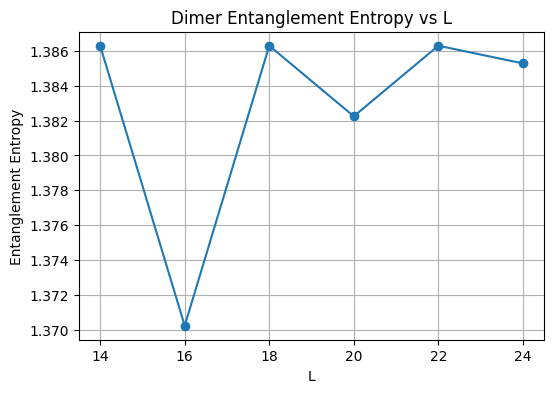

In [17]:
plt.figure(figsize=(6,4))
plt.plot(Ltar, dimer_ee_tar, marker='o')
#plt.xscale('log')
#plt.plot(Ltar, np.log(np.pi*np.asarray(Ltar)), linestyle='--', color='gray', label='log(L)')
plt.xlabel('L')
plt.ylabel('Entanglement Entropy')
plt.title('Dimer Entanglement Entropy vs L')
plt.grid(True)
plt.show()